# Demo of MRI Reconstruction Technics

In this notebook we review some results on MRI image reconstruction, based on sampling of the fourier domain.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *

/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/pysap_mri-0.2.2-py3.9.egg/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
/home/pac/.pyenv/versions/mri/lib/python3.9/site-packages/pysap_mri-0.2.2-py3.9.egg/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README


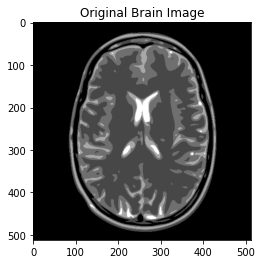

In [2]:
img_size = 512
mri_img = load_image("BrainPhantom", img_size)
plot_gray(mri_img,"Original Brain Image")

## Simulate Noise
A white gaussian noise  is added to the original image. The goal will be to reconstruct such image by sampling the frequency space. 

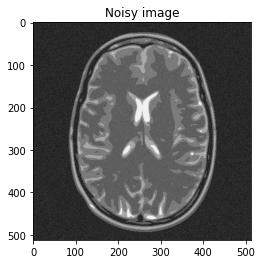

In [3]:
new_img = np.copy(mri_img.astype('float64'))
new_img += np.random.randn(*mri_img.shape) * 10.
plot_gray(new_img, "Noisy image")

## Cartesian sampling

### Trivial Sampling

### Low frequency (center line)

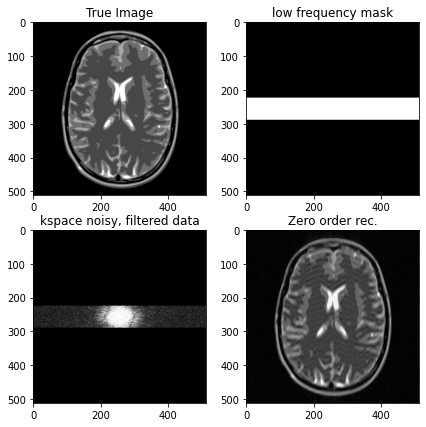

In [4]:
factor_ctr = 8
mask = np.zeros_like(mri_img,dtype=bool)
low_res_size = img_size // factor_ctr + 1
idx_vec = np.linspace(img_size // 2 - low_res_size // 2,
                      img_size // 2 + low_res_size // 2,
                      low_res_size, dtype=int)

mask[idx_vec,: ] = True
kspace_data = fft(mri_img)

signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= mask
# get back to the convention
image_rec0 = ifft(kspace_data)            
kspace_data_abs = np.abs(kspace_data)
subplots([(mri_img, "True Image"),
          (mask, "low frequency mask"),
          (np.clip(kspace_data_abs,0,np.percentile(kspace_data_abs,99)),"kspace noisy, filtered data"),
          (np.abs(image_rec0), "Zero order rec.")])


And with a center square mask

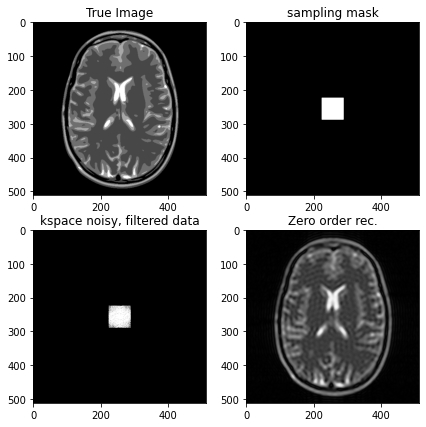

In [5]:
maskSquare = mask * mask.T
mask_reco(mri_img,maskSquare)


### High frequency (square box)

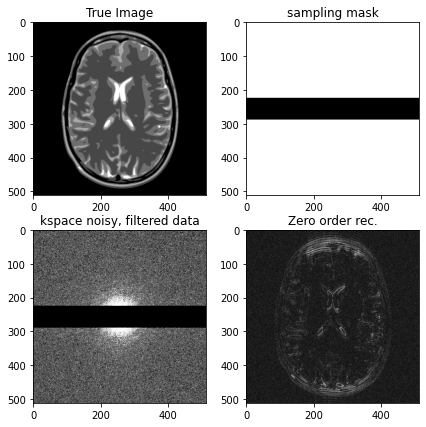

In [6]:
maskHigh = np.logical_not(mask)
mask_reco(mri_img,maskHigh)


## iid Variable sampling
In this section we consider the use of _iid variable density sampling_. 
sampling_
either from:
* **optimal distributions** from the CS theory on orthonormal systems for Shannon wavelets derived in:
    -   Chauffert et al, "Variable density compressed sensing in MRI. Theoretical vs heuristic sampling strategies", Proc. 10th IEEE ISBI 2013: 298-301
    -  Chauffert et al, "Variable Density Sampling with Continuous Trajectories" SIAM Imaging Sci, 2014;7(4):1992-1992) 

* or from handcrafted densities parameterized by the decay $\eta$: 
$$
p(k_x,k_y) =1/\left(k_x^2+k_y^2\right)^{\eta/2}, \quad \eta \simeq 3.
$$

#### Optimal Distribution

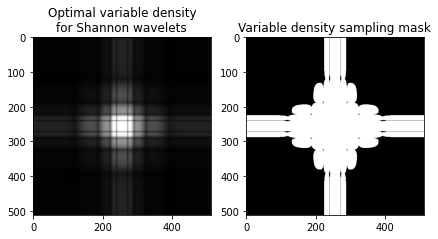

In [7]:
from scipy.io import loadmat

densities = loadmat("data/2d_sampling_densities.mat")
opt_density = densities[f'distrib2d_N{img_size}_sym10']


# Generate Cartesian variable density mask
# change the value below if you want to change the final subsampling mask
threshold = 10. * opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size, img_size), dtype="float64")
kspace_mask = np.where(opt_density > threshold, 1, kspace_mask)
subplots([(opt_density,"Optimal variable density\nfor Shannon wavelets"),
          (kspace_mask,"Variable density sampling mask")],figsize=(7,4))
          


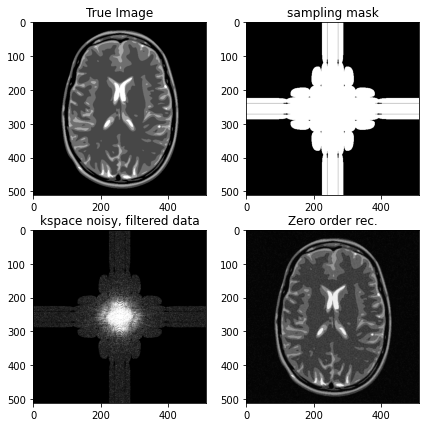

In [8]:
mask_reco(mri_img,kspace_mask)

### handcrafted Distribution

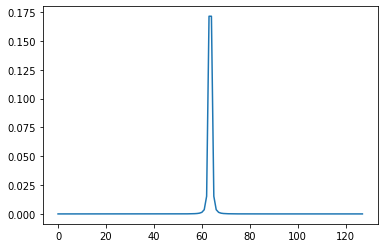

In [9]:
# Now construct by hands a variable sampling distribution 
# You can change the decay to modify the decreasing behavior in the center of k-space
# the larger the decay, the faster the decrease from low to high-frequencies
decay = 3
x = np.linspace(-1. / (2. * np.pi), 1. / (2. * np.pi), img_size)
X, Y = np.meshgrid(x, x)
r = np.sqrt(X ** 2 + Y ** 2)
#print(r)
p_decay = np.power(r,-decay)
p_decay = p_decay/np.sum(p_decay)

plt.plot(p_decay[p_decay.shape[0]//2, 3*p_decay.shape[1]//8:5*p_decay.shape[1]//8])
plt.show()

In [10]:
# change the value below if you want to change the final subsampling mask
threshold = 2* opt_density.min()  # sys.float_info.epsilon \simeq 2e-16
kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask = np.where(p_decay > threshold, 1, kspace_mask)

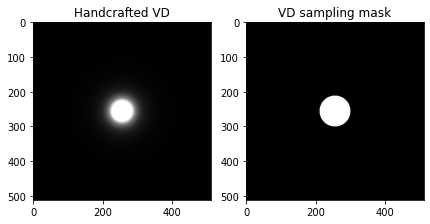

In [11]:
subplots([(np.clip(p_decay,0,np.percentile(p_decay,99)),"Handcrafted VD"),
         (kspace_mask, "VD sampling mask")])

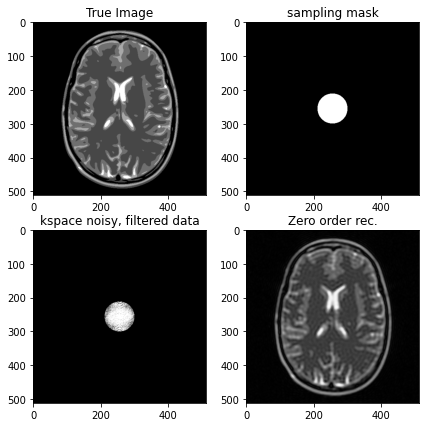

In [12]:
mask_reco(mri_img,kspace_mask)

# Third exercice: 1D Cartesian structured VDS along  parallel lines

we perform pseudo-random variable density sampling along the phase encoding direction. 
A handcrafted density is designed and samples are then drawn by virtually inverting its cumulative density function. Then these samples define the selected phase encoding lines retained in the sampling mask. Low frequencies are more sampled than higher frequencies. 

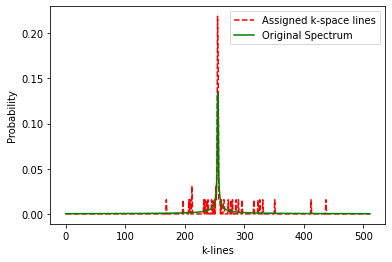

36


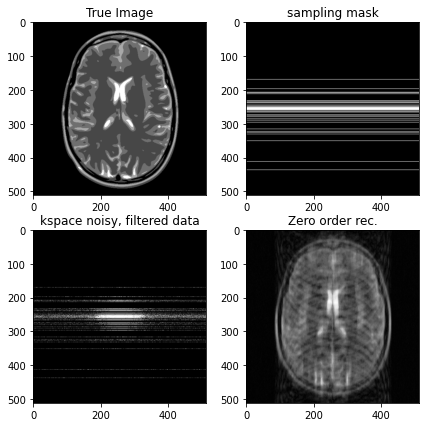

In [13]:
# define the taret sampling density (ie non-iniform over k-space lines)
decay = 1.
# Define the sampling density
kspace_lines = np.linspace(-1/2., 1/2.,img_size)*img_size
p_decay = np.power(np.abs(kspace_lines),-decay)
p_decay = p_decay/np.sum(p_decay)
# generate its CDF
cdf_pdecay = np.cumsum(p_decay)


pmax = p_decay.max()
pmin = p_decay.min()

# Perform pseudo-random sampling: technique used:
# draw uniform variables and invert the CDF to get back to p_decay-distributed sampled
nb_samples = img_size//8
samples = np.random.uniform(0, 1, nb_samples)
kspace_lines = kspace_lines.astype(int)
gen_klines = [np.argmin(abs(cdf_pdecay - s)) for s in samples]

# check that histogram of sample values fits the prescribed density p_decay
lc = np.bincount(gen_klines, minlength=512)
plt.figure()
plot1, = plt.plot(lc/sum(lc), 'r--', label='Assigned k-space lines')
plot2, = plt.plot(p_decay,'g',label='Original Spectrum')
plt.xlabel('k-lines')
plt.ylabel('Probability')
plt.legend(handles=[plot1,plot2])
plt.show()

sampled_klines = np.unique(gen_klines)
nblines = np.size(sampled_klines)
print(nblines)

kspace_mask = np.zeros((img_size,img_size), dtype="float64")
kspace_mask[sampled_klines,:] = np.ones((nblines,img_size) , dtype="float64")

mask_reco(mri_img,kspace_mask)


### Regular sampling and its artifacts
In the previous section we choose pseudo-random sampling lines of the k-space. why not use a regular sampling method instead ? 

The short answer: don't. regular sampling rimes with artifacts and aliasing. 



2-fold undersampling, m=  256
4-fold undersampling, m=  128
8-fold undersampling, m=  64


Text(0.5, 1.0, 'Cartesian regular under-sampling mask (R=8)')

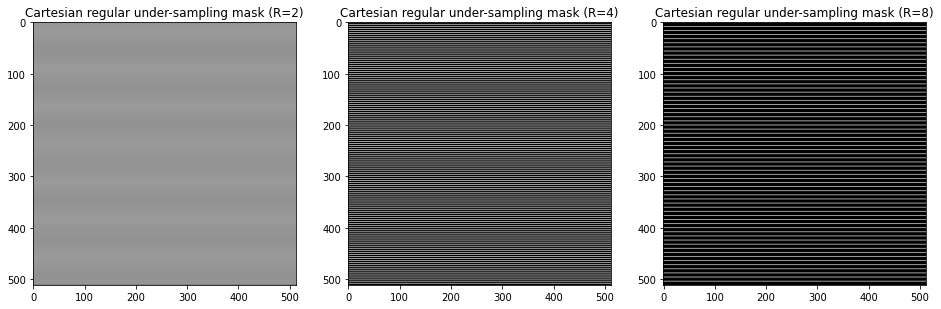

In [14]:
# generate Cartesian lines in a straightforward manner
#a = (np.linspace(0,img_size,img_size+1))/img_size -0.5    # work in normalized frequency
r2 = (int)(img_size/2)
r4 = (int)(img_size/4)
r8 = (int)(img_size/8)
print("2-fold undersampling, m= ", r2)
print("4-fold undersampling, m= ", r4)
print("8-fold undersampling, m= ", r8)

selected_ksp_line = np.ones((1, img_size), dtype="float64")
skipped_ksp_line = np.zeros((1, img_size), dtype="float64")
k_space_pattern_r2 = np.concatenate((selected_ksp_line, skipped_ksp_line), axis=0)
kspace_mask_r2 = np.tile(k_space_pattern_r2, (r2, 1))

#k_space_pattern_r4 = np.concatenate((selected_ksp_line, skipped_ksp_line, skipped_ksp_line,skipped_ksp_line), axis=0)
k_space_pattern_r4 = np.concatenate((selected_ksp_line, np.tile(skipped_ksp_line, (3,1))), axis=0)
kspace_mask_r4 = np.tile(k_space_pattern_r4, (r4, 1))

k_space_pattern_r8 = np.concatenate((selected_ksp_line, np.tile(skipped_ksp_line, (7,1))), axis=0)
kspace_mask_r8 = np.tile(k_space_pattern_r8, (r8, 1))


fig, axs = plt.subplots(1, 3, figsize=(16, 16) )
axs[0].imshow(kspace_mask_r2,cmap='Greys_r') #, cmap='Greys_r'
axs[0].set_title("Cartesian regular under-sampling mask (R=2)")
axs[1].imshow(kspace_mask_r4, cmap='Greys_r')
axs[1].set_title("Cartesian regular under-sampling mask (R=4)")
axs[2].imshow(kspace_mask_r8, cmap='Greys_r')
axs[2].set_title("Cartesian regular under-sampling mask (R=8)")

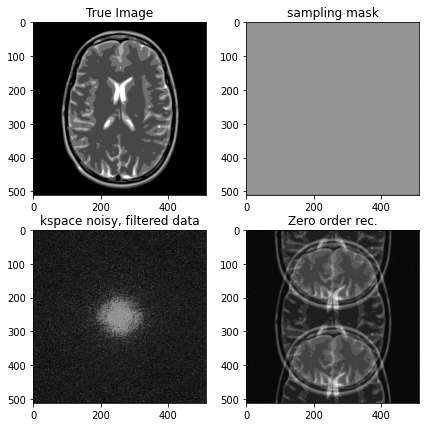

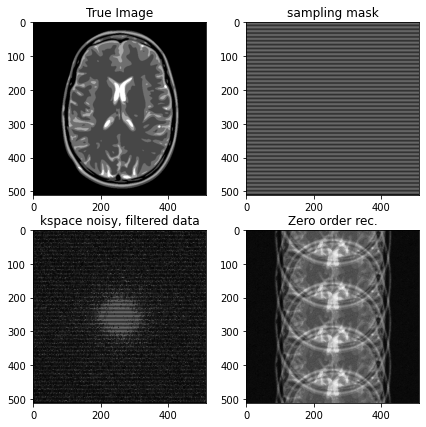

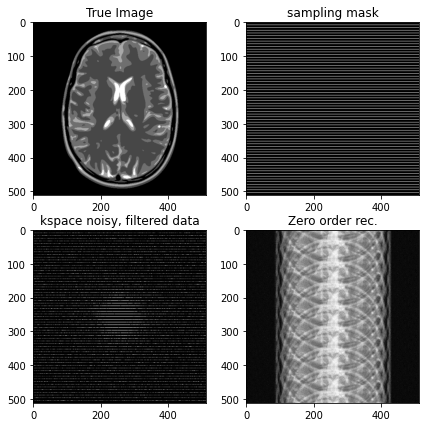

In [15]:
mask_reco(mri_img,kspace_mask_r2)
mask_reco(mri_img,kspace_mask_r4)
mask_reco(mri_img,kspace_mask_r8)


<div class="alert alert-warning">
    <b>REMARK</b>:
     <ul>
      <li> The image representation of the different mask suffer from the pixel density of you screen and the size of its representation, thus gray stripes may appear (instead of sharp black and whites ones          
         </li>
    </ul>
</div>

<div class="alert alert-success">
     <ul>
      <li>
        the periodicity of the sampling is visible in the image domain; for example a periodicy of two pixel (for 512 pixel image wide) in fourier domain is equivalent to a periodicy of 256. 
          The resulting superposition of the skull is aliasing. to prevent it, one may use a low pass filter. 
        </li>
        </ul>
</div>


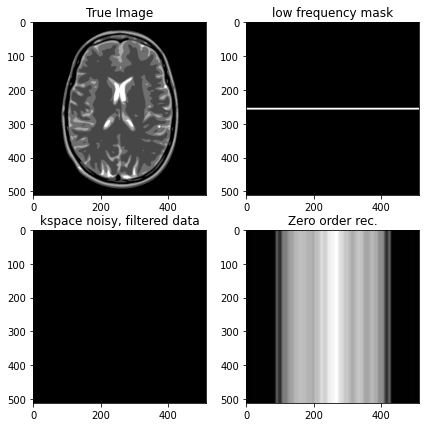

In [16]:
factor_ctr = 128
mask = np.zeros_like(mri_img,dtype=bool)
low_res_size = img_size // factor_ctr + 1
idx_vec = np.linspace(img_size // 2 - low_res_size // 2,
                      img_size // 2 + low_res_size // 2,
                      low_res_size, dtype=int)

mask[idx_vec,: ] = True
kspace_data = fft(mri_img)

signoise = 10
kspace_data += np.random.randn(*mri_img.shape) * signoise * (1+1j)
# Mask data to perform subsampling
kspace_data *= mask * kspace_mask_r4
# get back to the convention
image_rec0 = ifft(kspace_data)            
kspace_data_abs = np.abs(kspace_data)
subplots([(mri_img, "True Image"),
          (mask, "low frequency mask"),
          (np.clip(kspace_data_abs,0,np.percentile(kspace_data_abs,99)),"kspace noisy, filtered data"),
          (np.abs(image_rec0), "Zero order rec.")])

No more aliasing, but it does not look very good anymore ...

# Non Cartesian Sampling
Since then, we only used cartesian sampling (eg orthogonal lines from the k-space plane). what happen when we use other pattern for sampling the k-space domain ?

## Radial sampling

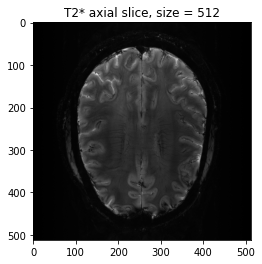

In [17]:

from mri.operators import NonCartesianFFT
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from pysap.data import get_sample_data


from skimage import data, img_as_float, io, filters
from modopt.math.metrics import ssim

mri_img = get_sample_data('2d-mri')
img_size = mri_img.shape[0]

plt.figure()
plt.title("T2* axial slice, size = {}".format(img_size))
if mri_img.ndim == 2:
    plt.imshow(mri_img, cmap=plt.cm.gray)
else:
    plt.imshow(mri_img)
plt.show()

In [18]:
# set up the first shot
rfactor = 8
nb_shots = np.ceil(img_size/rfactor)
print("number of shots: {}".format(nb_shots))

# vectorize the nb of shots    
vec_shots = np.arange(0,nb_shots)

# define the regularly spaced samples on a single shot
nsamples = (np.arange(0,img_size) - img_size//2)/(img_size)
print("number of samples per shot: {}".format(np.size(nsamples)))

shot_c = np.array(nsamples, dtype = np.complex_)
shots = np.array([], dtype = np.complex_)    
# acculumate shots after rotating the initial one by the right angular increment        
for k in vec_shots:
    shots = np.append(shots, shot_c * np.exp(2 * np.pi * 1j * k/(2*nb_shots)))

kspace_loc = np.zeros((len(shots),2))
#assign real and imaginary parts of complex-valued k-space trajectories to k-space locations
kspace_loc[:,0] = shots.real
kspace_loc[:,1] = shots.imag


number of shots: 64.0
number of samples per shot: 512


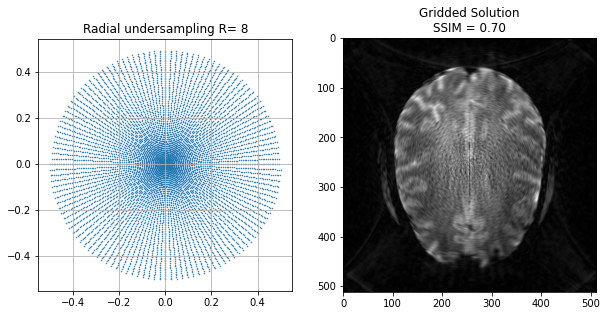

In [19]:
non_cart_sampling(mri_img, kspace_loc, f"Radial undersampling R= {rfactor}")

<div class="alert alert-success">
     <ul>
      <li>
        The radial sampling creates ringing artifacts, due to the circular symmetry of the sampling method.
        </li>
        </ul>
</div>

### Spiral Sampling

In [20]:
def complex_to_2d(points):
    X = points.real
    Y = points.imag
    return np.asarray([X, Y]).T


number of shots: 64.0
number of samples: 256
number of samples per shot: 512
(32768,)


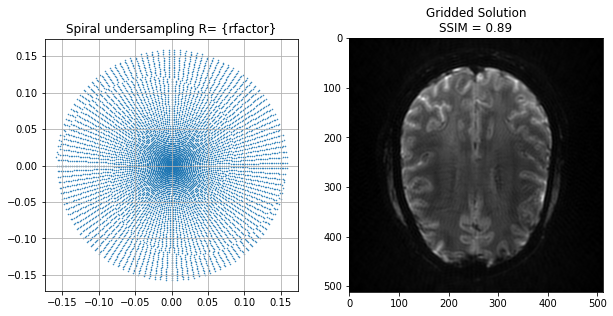

In [21]:
# set up the first shot
rfactor = 8
num_shots = np.ceil(img_size/rfactor)
print("number of shots: {}".format(num_shots))

# define the regularly spaced samples on a single shot
#nsamples = (np.arange(0,img_size) - img_size//2)/(img_size)
num_samples = img_size
num_samples = (num_samples + 1) // 2
print("number of samples: {}".format(num_samples))
num_revolutions = 1

shot = np.arange(0, num_samples, dtype=np.complex_)
radius = shot / num_samples * 1 / (2 * np.pi) * (1 - np.finfo(float).eps)
angle = np.exp(2 * 1j * np.pi * shot / num_samples * num_revolutions)
# first half of the spiral
single_shot = np.multiply(radius, angle)
# add second half of the spiral
#single_shot = np.append(np.flip(single_shot, axis=0), -single_shot[1:])
single_shot = np.append(np.flip(single_shot, axis=0), -single_shot)
#print(single_shot)
print("number of samples per shot: {}".format(np.size(single_shot)))

# vectorize the nb of shots    
#vec_shots = np.arange(0,nb_shots + 1)

k_shots = np.array([], dtype = np.complex_)  
#for i in vec_shots:
for i in np.arange(0, num_shots):
    shot_rotated = single_shot * np.exp(1j * 2 * np.pi * i / (num_shots * 2))
    k_shots = np.append(k_shots, shot_rotated)
    #np.append(k_shots, complex_to_2d(shot_rotated))

print(k_shots.shape)
kspace_loc = np.zeros((len(k_shots),2))
kspace_loc[:,0] = k_shots.real
kspace_loc[:,1] = k_shots.imag

non_cart_sampling(mri_img, kspace_loc, "Spiral undersampling R= {rfactor}")


### Sparkling 

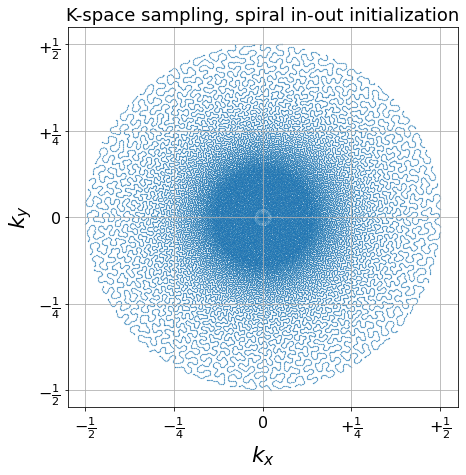

In [22]:
k_spark = loadmat("data/samples_SPARKLING_N512_nc34x3073_OS1.mat")
k_spark_vec = k_spark['samples']

Kmax = np.amax(k_spark_vec)
#print(Kmax)

k_spark_vec = k_spark_vec*1/(2*np.pi*Kmax)

#save in npz format in the outdir directory
outdir = "output"
filename_traj = "sparkling_radial_N"  + str(img_size) + ".npz"
outfile = os.path.join(outdir, filename_traj)
np.savez(outfile, k_spark_vec)

k_spark = plt.figure(figsize=(7,7))
plt.scatter(k_spark_vec[:,0],k_spark_vec[:,1], marker = '.', s=0.1)
plt.grid()
#Figure layout

unit = 1/4
tick = np.arange(-0.5, 0.5 + unit, unit)

label = [r"$-\frac{1}{2}$", r"$-\frac{1}{4}$", r"$0$", r"$+\frac{1}{4}$",  r"$+\frac{1}{2}$"]

plt.xticks(tick/np.pi,labels = label, fontsize = 16) ; plt.yticks(tick/np.pi,labels = label, fontsize = 16)

plt.xlabel(r"$k_x$", fontsize = 22) ; plt.ylabel(r"$k_y$", fontsize = 22)

plt.title("K-space sampling, spiral in-out initialization",fontsize = 18)

plt.show()



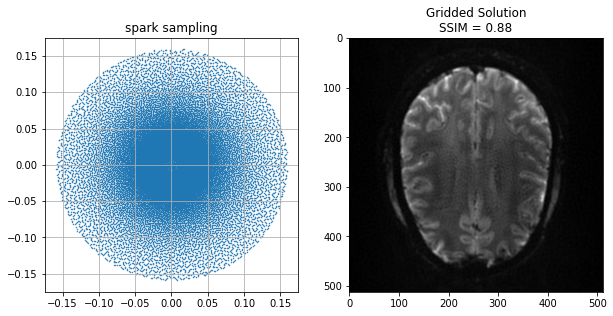

In [23]:
non_cart_sampling(mri_img, k_spark_vec,"spark sampling")


This conclude the various sampling methods we use to retrive data from the k-space domain.

| Method      | Cost   | Results   | Comments                           |
|-------------|--------|-----------|------------------------------------|
| Low Pass    | Low    | Bad       |                                    |
| 1D regular  | Low    | Very Bad  | aliasing                           |
| 1D random   | Medium | Medium    |                                    |
| custom mask | Medium | Good      | choice of the Mask very important  |
| Radial      | High   | Good      | non uniform fft + aliasing         |
| Spiral      | High   | Good      | non uniform fft                    |
| Sparkling   | High   | Very Good | need pre-determined sampling path  |


## Compress Sensing Reconstruction
In the previous example we have build zero-order reconstruction, without taking into account any prior. In the following, we will make the hypothese of a sparse representation in the wavelet domain and thus, use compress sensing iterative algorithm (FISTA, Conda-VU) to reconstruct the images
Sparsity will be promoted in the wavelet domain, using either Symmlet-8 (analysis and synthesis) or undecimated bi-orthogonal wavelets (analysis only).

We remind that the synthesis formulation reads (minimization in the sparsifying domain):
$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \|y - \Omega F \Psi^*z \|_2^2 + \lambda \|z\|_1
$$
and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$. For an orthonormal wavelet transform, 
we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.

while the analysis formulation consists in minimizing the following cost function (min. in the image domain):
$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \|y - \Omega F x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$
### Cartesian Samples

In [24]:
# Package import
from modopt.math.metrics import ssim
#from mri.numerics.fourier import FFT2
#from mri.numerics.reconstruct import sparse_rec_condatvu, sparse_rec_fista
#from mri.numerics.utils import generate_operators
#from mri.numerics.utils import convert_mask_to_locations

from mri.operators import FFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

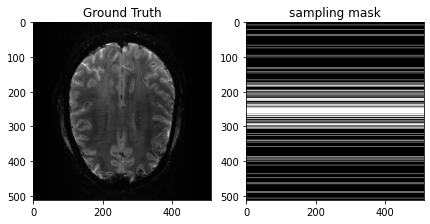

In [26]:
image = get_sample_data('2d-mri')

# Obtain K-Space Cartesian Mask
mask = get_sample_data("cartesian-mri-mask")


# View Input
subplots([(image,'Ground Truth'),(mask, 'Sampling mask')])

To initialize the reconstruction, let's use the zero order reconstruction.

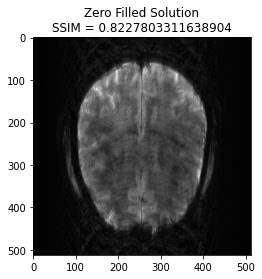

In [27]:
kspace_loc = convert_mask_to_locations(mask.data)
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)
image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data),
                         metadata=image.metadata)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()


#### FISTA: synthesis formulation

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [29]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1000000000000534
The lipschitz constraint is satisfied


 - mu:  2e-07
 - lipschitz constant:  1.1000000000000534
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f5c2c364b50> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:22 Time:  0:00:22


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  22.231968364998465  seconds
----------------------------------------


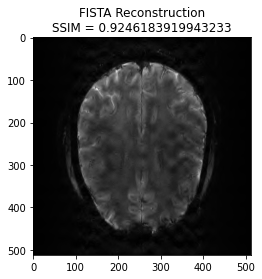

In [30]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()


#### Conda-Vu: Analysis method

In [32]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

In [33]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.0999999999999999
The lipschitz constraint is satisfied


 - mu:  2e-07
 - lipschitz constant:  1.0999999999999999
 - tau:  0.9374654926116563
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7f5c2c7359d0> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:07:31 Time:  0:07:31


 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  456.3772241100087  seconds
----------------------------------------


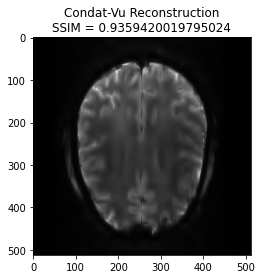

In [34]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()


Without tweks,  the Conda-Vu  algorithm is 20 times slower than FISTA, for a minor improvement of the solution. 

### Radial Samples

[====================] 100% samples_radial_GA_nc64_ns512.npy        
Download was done in 0 minutes,  4.53 seconds


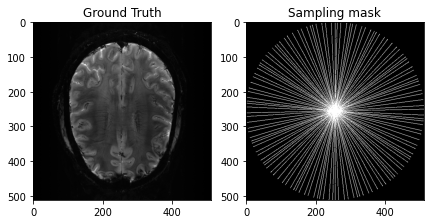

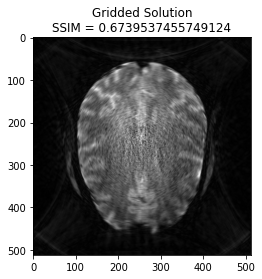

In [35]:
image = get_sample_data('2d-mri')
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))
subplots([(image,'Ground Truth'),(mask, 'Sampling mask')])

#fourier_op = NFFT(samples=kspace_loc, shape=image.shape)
#kspace_obs = fourier_op.op(image.data)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(image.data)
# zero order approx
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, image)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

#### FISTA

Lipschitz constant is 570.4522582691394
The lipschitz constraint is satisfied
 - mu:  6e-07
 - lipschitz constant:  570.4522582691394
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f5c2c2b6550> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:42 Time:  0:00:42


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  42.785681084991666  seconds
----------------------------------------


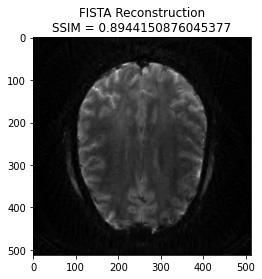

In [39]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 6 * 1e-7, thresh_type="soft")
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

#### Conda-Vu

Lipschitz constant is 570.4522582292535
The lipschitz constraint is satisfied
 - mu:  6e-07
 - lipschitz constant:  570.4522582292535
 - tau:  0.0034996503056475303
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7f5c2769e940> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:07:41 Time:  0:07:41


 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  466.20246929099085  seconds
----------------------------------------


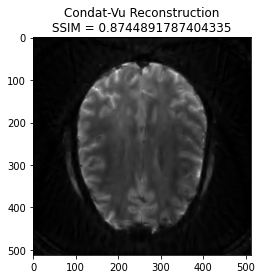

In [40]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()



### Conclusion


By using compress sensing technics, we can reach better results, but with a higher computational cost. The time cost maybe transform into a hardware cost by using dedicated hardware (parallel reconstruction on GPU for example). One could also decide to start the reconstruction during the acquisition (so called on-line reconstruction), study this part will be part of my internship. 
